In [1]:
!pip install --upgrade pandas numpy matplotlib seaborn scikit-learn shap

  Using cached numpy-1.23.2-cp39-cp39-win_amd64.whl (14.7 MB)
  Using cached matplotlib-3.5.3-cp39-cp39-win_amd64.whl (7.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\1\\anaconda3\\Lib\\site-packages\\~-mpy\\.libs\\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
np.random.seed(123)
import seaborn as sns
import matplotlib.pyplot as plt

import shap
print(f"Shap version used: {shap.__version__}")
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor

### SHAP Errata

Хотя мне очень понравилась идея алгоритма SHAP, но, к сожалению, фреймворк SHAP Python имеет много проблем, особенно с последней версией (0.40.0), которую я использую при создании этого руководства.

Есть много незавершенных запросов на извлечение, которые владельцы проекта должны были бы рассмотреть и одобрить, и мне было грустно видеть, что владельцы проекта не проявляют активного внимания к проекту. Если вы столкнетесь с какой-либо проблемой, пожалуйста, сначала проверьте открытые проблемы для SHAP по адресу: https://github.com/slundberg/shap/issues В настоящее время, когда я пишу эту книгу, существует более 1,3 тыс. открытых проблем и около 100 непросмотренных запросов на извлечение.

Я сам столкнулся с несколькими проблемами, связанными с запуском фреймворка, и мне пришлось глубоко копаться в коде фреймворка и вносить необходимые изменения, чтобы устранить ошибку. Хотя ошибки довольно тривиальны, но начинающим ученикам трудно самостоятельно их выявить и исправить. Итак, я включаю раздел с ОШИБКАМИ SHAP, чтобы решить известные проблемы, с которыми я столкнулся в процессе написания.

Пожалуйста, проверьте https://github.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/blob/main/Chapter06/SHAP_ERRATA/ReadMe.md прежде чем продолжить.

Набор данных о качестве красного вина - Kaggle

Набор данных относится к красному варианту португальского вина "Vinho Verde". Для получения более подробной информации обратитесь к ссылке [Cortez et al., 2009]. Из-за конфиденциальности и логистических проблем доступны только физико-химические (входные данные) и сенсорные (выходные данные) переменные (например, нет данных о сортах винограда, марке вина, цене продажи вина и т.д.). Мы будем использовать этот набор данных для решения регрессионной задачи.

In [5]:
# We will read the training data
data = pd.read_csv('C:\\Users\\1\\Downloads\\winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
data.shape

(1599, 12)

In [7]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [9]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [10]:
# Dropping missing values
data.fillna(0,inplace=True)
data.shape

(1599, 12)

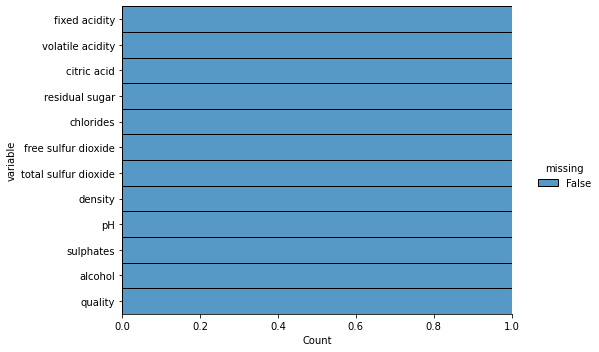

In [11]:
# Handling missing values
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.5
)
plt.show()

В данных не обнаружено пропущенных значений. Мы можем приступить к процессу обучения модели.

In [17]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
from sklearn.model_selection import train_test_split 

In [14]:
features = data.drop(columns=['quality'])
labels = data['quality']
# Dividing the data into training-test set with 80:20 split ratio
x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.2, random_state=123)

In [18]:
model = RandomForestRegressor(n_estimators=2000, max_depth=30, random_state=123)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=2000, random_state=123)

In [19]:
model.score(x_test, y_test)

0.49976030471036337

In [22]:
pip install shap

  Using cached shap-0.41.0-cp39-cp39-win_amd64.whl (435 kB)
  Using cached slicer-0.0.7-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [23]:
import shap

### Using SHAP for model interpretability

In [24]:
explainer = shap.Explainer(model)
shap_values = explainer(x_test)

SHAP предоставляет множество вариантов визуализации для объяснения работы модели. Но некоторые визуализации могут показаться сложными, поэтому я попытаюсь объяснить, что визуализация пытается рассказать в следующем разделе.

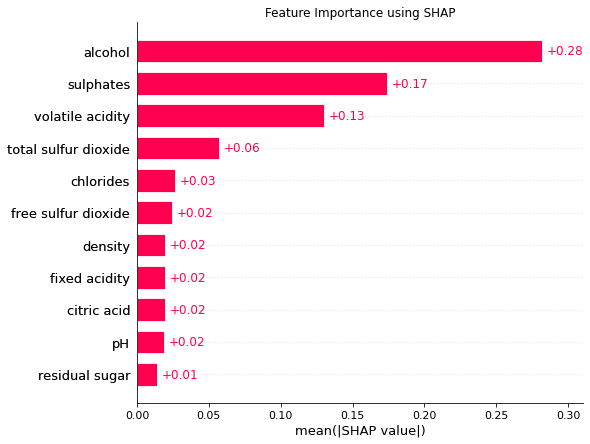

In [25]:
plt.title('Feature Importance using SHAP')
shap.plots.bar(shap_values, show=True, max_display=12)

Важность признака - один из наиболее распространенных методов объяснения модели. Вместо вычисления важности признаков с точки зрения взвешенной изученной модели, SHAP предоставляет независимый от модели подход для выделения наиболее влиятельных признаков на основе средних абсолютных значений SHAP.

Pro - Прост в интерпретации и очень полезен для определения доминирующих функций на основе коллективного взаимодействия с другими функциями с использованием значений SHAP.
Con - Поскольку он показывает характеристики, основанные на средних абсолютных значениях Shap, трудно определить характеристики, которые положительно влияют на модель и отрицательно влияют на модель.

### Global interpretability with heatmap plots

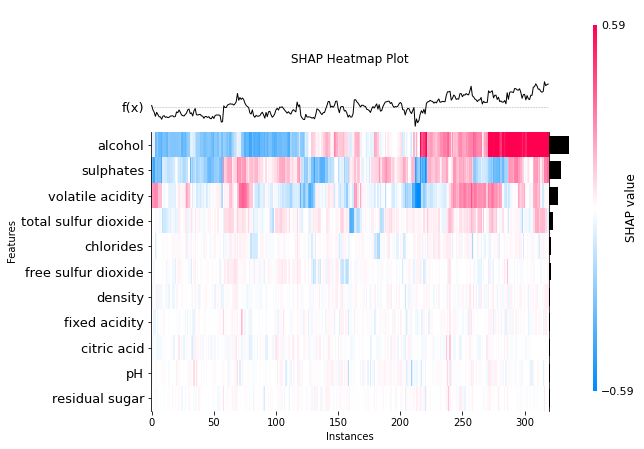

In [26]:
plt.title('SHAP Heatmap Plot')
shap.plots.heatmap(shap_values, max_display=12, show=False)
plt.gcf().axes[-1].set_box_aspect(100)
plt.ylabel('Features')
plt.show()

Тепловые карты необходимы для понимания общего влияния всех функций на модель. Тепловая карта, показанная выше, показывает, как качество спирта повышается с увеличением количества спирта и сульфатов, поскольку эти характеристики имеют более высокие значения shap, обозначенные красной областью. Кривая f(x) вверху показывает, как прогнозируемое значение качества вина увеличивается с увеличением количества экземпляров данных. Это может быть связано с тем, что содержание алкоголя и сульфатов положительно влияет на результат.

Pro - Показывает наиболее важные функции и то, как общий прогноз меняется в зависимости от экземпляров данных.
Con - Может быть сложным для интерпретации для любого обычного пользователя.

### Global interpretability with Cohort plots

Пожалуйста, обратите внимание - Проверьте раздел с ошибками SHAP, прежде чем продолжить работу с этим разделом! Я столкнулся с ошибкой в фреймворке, которая является известной проблемой, когда я создаю этот учебник: https://github.com/slundberg/shap/issues/2325 и решение представлено в https://github.com/yuuuxt/shap/commit/7c95fd2b48bcf9cad82b10f65e552a49b360afbd который по-прежнему является открытым запросом на вытягивание. Пожалуйста, попробуйте решение, опубликованное в разделе SHAP Errata, если вы получите какую-либо ошибку при получении значений когорты.

In [27]:
# index of the feature alcohol is 10
f_idx = 10
alcohol = ["High Alcohol" if shap_values[i].data[f_idx] >=10.0 else "Low Alcohol" for i in range(shap_values.shape[0])]

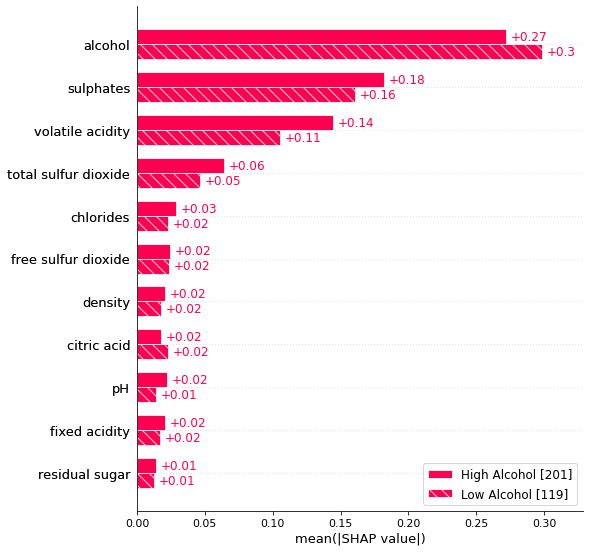

In [28]:
shap.plots.bar(shap_values.cohorts(alcohol).abs.mean(0), max_display=12)

SHAP предоставляет уникальный способ формирования подгрупп или когорт для анализа важности признаков. Я обнаружил, что это уникальная опция в SHAP, которая может быть действительно полезной! Но те же плюсы и минусы остаются, как и у сюжетов SHAP bar.

### Global interpretability with feature clustering

12it [01:04,  6.46s/it]                                                                                                


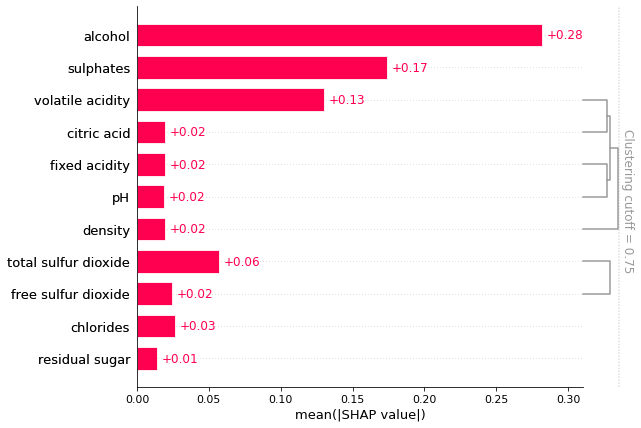

In [29]:
clustering = shap.utils.hclust(x_test, y_test)
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.75, max_display = 12)

Это еще одна интересная визуализация от SHAP. Кластеризация объектов помогает нам визуализировать сгруппированные объекты или объекты, которые имеют высокую степень взаимодействия друг с другом. Как мы можем видеть из изображения, летучая кислотность и лимонная кислота образуют группу, а рН и фиксированная кислотность образуют другую группу, но в совокупности эти подгруппы взаимодействуют с плотностью и образуют иерархический кластер. Таким образом, этот метод использует иерархическую кластеризацию для поиска объектов, которые имеют высокую степень взаимодействия друг с другом и влияют на модель при коллективном подходе.

### Global interpretability with SHAP summary plots

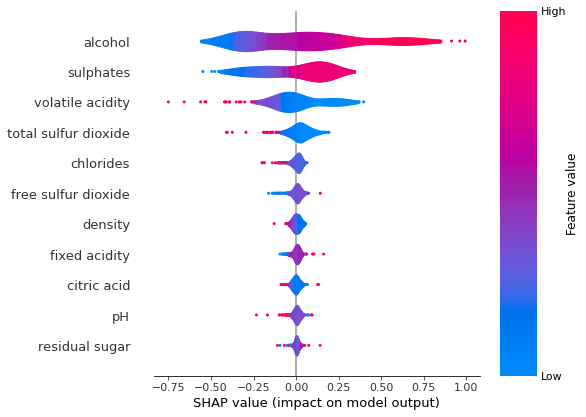

In [30]:
shap.summary_plot(shap_values, x_test, plot_type="violin", show=False)
plt.gcf().axes[-1].set_box_aspect(10)
plt.show()

Сводные графики SHAP - это интересная визуализация, которая действительно дает много информации, и она намного лучше, чем гистограммы важности объектов. Мы можем получить следующую информацию из сводных графиков SHAP.

Важность объектов на основе значений Шепли - График показывает важность объектов в порядке убывания их важности на основе значений Шепли. Визуализация горизонтального графика скрипки показывает положительное или отрицательное влияние объекта на некоторые точки данных. Но влияние значений функций отображается от высокого к низкому с использованием интересных цветовых сочетаний.
Корреляция признаков - цвет горизонтальных графиков для каждого объекта показывает положительную или отрицательную корреляцию с целевым результатом. Из графика мы можем сказать, что, поскольку алкоголь чаще всего изображается с градиентом красного цвета, он имеет положительную корреляцию с качеством вина, тогда как летучая кислотность изображается с градиентом синего цвета, что указывает на то, что она имеет отрицательную корреляцию с целевым выходом.

In [31]:
### Global interpretability with feature dependence plot

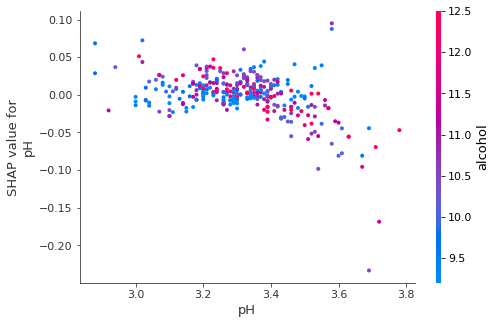

In [32]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)
shap.dependence_plot("pH", shap_values, x_test, show=False)
plt.gcf().axes[-1].set_box_aspect(50)

График зависимости помогает нам определить частичную зависимость конкретного объекта от другого объекта. Из визуализации мы можем сделать вывод, что вина с более высоким содержанием алкоголя имеют несколько меньшие значения рН. Это интересный сюжет для изучения взаимодействия между влиятельными функциями.

### Local interpretability with force plot

In [33]:
# Initialization of javascript visualization in notebooks
shap.initjs()

In [34]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test.iloc[0,:], plot_cmap="PkYg")

### Local interpretability using Waterfall plots

Пожалуйста, обратите внимание - Проверьте раздел с ошибками SHAP, прежде чем продолжить работу с этим разделом! Я столкнулся с ошибкой в фреймворке, которая является известной проблемой, когда я создаю этот учебник: ссылка на проблему GitHub - https://github.com/slundberg/shap/issues/2261 . Пожалуйста, попробуйте решение, опубликованное в разделе SHAP Errata, если вы получите какую-либо ошибку при использовании графика водопада.


In [ ]:
figure = plt.figure(figsize=(25,12))
ax1 = figure.add_subplot(121)

explainer = shap.Explainer(model, x_test)
shap_values = explainer(x_test)
# For the test observation with index 0
shap.plots.waterfall(shap_values[0], max_display = 12, show=False)
ax1.title.set_text(f'The First Observation.\nModel prediction: {model.predict(x_test)[0]}')

ax2 = figure.add_subplot(122)
# Similarly for the test observation with index 1
shap.plots.bar(shap_values[1], max_display = 12, show=False) 
ax2.title.set_text(f'The Second Observation.\n Model prediction: {model.predict(x_test)[1]}')
plt.tight_layout()
plt.show()

 62%|============        | 198/320 [10:14<06:18]       

In [ ]:
shap.plots.waterfall(shap_values[1], max_display = 12) 

Участок водопада - еще один интересный участок с возможностью интерпретации на местном уровне, доступный в SHAP. Это лучше, чем графики важности признаков, поскольку показывает, как каждое значение признака в данных локального вывода вносит положительный или отрицательный вклад в прогнозирование модели. Как мы можем видеть из графика, для второго тестового наблюдения значение алкоголя ниже среднего значения и, следовательно, оно имеет отрицательное значение Шепли. Отрицательное значение Шепли указывает на то, что, хотя алкоголь является наиболее влиятельной характеристикой в наборе данных, но поскольку для текущего экземпляра данных вывода значение алкоголя ниже среднего значения, это отрицательно влияет на модель, давая более низкое значение прогноза для качества вина. Но по сравнению с графиками водопада, штриховые диаграммы SHAP сосредоточены на 0.

In [ ]:
shap.plots.bar(shap_values[0], max_display = 12)

### Local interpretability with decision plot

In [ ]:
expected_value = explainer.expected_value
figure = plt.figure(figsize=(10,5))
ax1 = figure.add_subplot(121)
shap_values = explainer.shap_values(x_test)[0]
shap.decision_plot(expected_value, shap_values, x_test, show=False)
ax1.title.set_text(f'The First Observation.\nModel prediction: {model.predict(x_test)[0]}')

ax2 = figure.add_subplot(122)
shap_values = explainer.shap_values(x_test)[1]
shap.decision_plot(expected_value, shap_values, x_test, show=False)
ax2.title.set_text(f'The Second Observation.\n Model prediction: {model.predict(x_test)[1]}')
plt.tight_layout()
plt.show()

Как отмечалось ранее, графики силы, гистограммы и даже графики водопада не показывают средние значения всех характеристик и средний прогнозируемый результат. Кроме того, если набор данных содержит слишком много объектов, то силовые графики чрезвычайно трудно интерпретировать. Именно тогда графики принятия решений более полезны для местных объяснений. Он показывает, где текущее локальное предсказание модели выше или ниже среднего прогнозируемого результата и наиболее влиятельных функций, а также то, как значение таких функций в локальном экземпляре данных влияет на результат модели. В двух показанных примерах в обоих случаях характеристики спирт, общий диоксид серы и сульфаты либо положительно, либо отрицательно влияют на модель, что приводит к более высокому или более низкому прогнозу модели соответственно. Другие особенности не оказывают существенного влияния на решение модели.